In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
import tensorflow as tf
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout # type: ignore
from tensorflow.keras.callbacks import EarlyStopping # type: ignore
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing

2023-08-04 23:22:49.040806: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-04 23:22:49.590789: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
pip install 'aif360[LawSchoolGPA]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'


In [2]:
#limit VRAM usage
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

2023-08-04 23:22:50.123746: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-04 23:22:50.141153: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-04 23:22:50.141318: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
# Load the dataset and create a dataframe with image paths and labels
dataset_path = "datasets/dataset3gcf/training"
images = []
labels = []
for folder in os.listdir(dataset_path):
    if os.path.isdir(os.path.join(dataset_path, folder)):
        for file in os.listdir(os.path.join(dataset_path, folder)):
            if file.endswith(".jpg"):
                images.append(os.path.join(dataset_path, folder, file))
                labels.append(folder)
df = pd.DataFrame({"image": images, "label": labels})

In [4]:
# Load the validation set and create a dataframe with image paths and labels
validation_path = "datasets/dataset3gcf/validation"
images = []
labels = []
for folder in os.listdir(dataset_path):
    if os.path.isdir(os.path.join(dataset_path, folder)):
        for file in os.listdir(os.path.join(dataset_path, folder)):
            if file.endswith(".jpg"):
                images.append(os.path.join(dataset_path, folder, file))
                labels.append(folder)
vf = pd.DataFrame({"image": images, "label": labels})

In [5]:
# Define a function to preprocess the images: resize, grayscale, histogram equalization
def preprocess_image(image_path):
  image = cv2.imread(image_path)
  image = cv2.resize(image, (64, 64))
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  image = cv2.equalizeHist(image)
  image = image / 255.0
  image = np.expand_dims(image, axis=2)
  return image

In [6]:
# Apply the preprocessing function to the images and convert the labels to numeric values
X_train = np.array([preprocess_image(image) for image in df["image"]])
y_train = np.array([0 if label == "male" else 1 for label in df["label"]])

X_test = np.array([preprocess_image(image) for image in vf["image"]])
y_test = np.array([0 if label == "male" else 1 for label in df["label"]])

In [7]:
# Split the data into train and test sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Create a binary label dataset from the train set for aif360
train_df = pd.DataFrame(X_train.reshape(-1, 64*64))
train_df["label"] = y_train
train_df["gender"] = 0
train_dataset = BinaryLabelDataset(favorable_label=1, unfavorable_label=0,
                                   df=train_df,
                                   label_names=["label"],
                                   protected_attribute_names=["gender"],
                                   unprivileged_protected_attributes=[0])


In [9]:
# Compute the disparate impact and statistical parity difference metrics for the train set
metric_dataset = BinaryLabelDatasetMetric(train_dataset,
                                          unprivileged_groups=[{"gender": 0}],
                                          privileged_groups=[{"gender": 1}])
print("Disparate impact:", metric_dataset.disparate_impact())
print("Statistical parity difference:", metric_dataset.statistical_parity_difference())

Disparate impact: nan
Statistical parity difference: nan


/home/megatron/miniconda3/envs/tf/lib/python3.9/site-packages/aif360/metrics/binary_label_dataset_metric.py:105: RuntimeWarning: invalid value encountered in double_scalars
  return (self.num_positives(privileged=privileged)


In [10]:
# Apply the reweighing algorithm to mitigate bias in the train set
RW = Reweighing(unprivileged_groups=[{"gender": 0}], privileged_groups=[{"gender": 1}])
train_dataset_rw = RW.fit_transform(train_dataset)

# Compute the metrics for the reweighted train set
metric_dataset_rw = BinaryLabelDatasetMetric(train_dataset_rw,
                                             unprivileged_groups=[{"gender": 0}],
                                             privileged_groups=[{"gender": 1}])
print("Disparate impact after reweighing:", metric_dataset_rw.disparate_impact())
print("Statistical parity difference after reweighing:", metric_dataset_rw.statistical_parity_difference())


Disparate impact after reweighing: nan
Statistical parity difference after reweighing: nan


/home/megatron/miniconda3/envs/tf/lib/python3.9/site-packages/aif360/algorithms/preprocessing/reweighing.py:66: RuntimeWarning: invalid value encountered in double_scalars
  self.w_p_fav = n_fav*n_p / (n*n_p_fav)
/home/megatron/miniconda3/envs/tf/lib/python3.9/site-packages/aif360/algorithms/preprocessing/reweighing.py:67: RuntimeWarning: invalid value encountered in double_scalars
  self.w_p_unfav = n_unfav*n_p / (n*n_p_unfav)


In [11]:
print(train_dataset_rw.features.shape)
print(train_dataset_rw.features.size)

(418, 4097)
1712546


In [12]:
# Extract the features and labels from the reweighted train set
X_train_rw = train_dataset_rw.features[:, :-1].reshape(-1, 64, 64, 1)
y_train_rw = train_dataset_rw.labels.ravel()

In [13]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(64, 64, 1)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))
model.summary()

2023-08-04 23:22:56.935552: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-04 23:22:56.935727: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-04 23:22:56.935845: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 128)        0

s-bus-pci#L344-L355
2023-08-04 23:22:57.330800: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-04 23:22:57.330925: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-04 23:22:57.331015: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7236 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:07:00.0, compute capability: 8.6


In [14]:
# Compile and fit the model on the reweighted train set
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
early_stopping = EarlyStopping(monitor="val_loss", patience=5)
history = model.fit(X_train_rw, y_train_rw, batch_size=32, epochs=50,
                    validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/50


2023-08-04 23:22:58.633291: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-08-04 23:22:59.183808: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-08-04 23:22:59.186186: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x24c4f550 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-04 23:22:59.186203: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2023-08-04 23:22:59.190028: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-08-04 23:22:59.301124: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the proce

14/14 [==============================] - 3s 24ms/step - loss: 0.6773 - accuracy: 0.6172 - val_loss: 0.5987 - val_accuracy: 0.7799
Epoch 2/50
14/14 [==============================] - 0s 5ms/step - loss: 0.5514 - accuracy: 0.7488 - val_loss: 0.4710 - val_accuracy: 0.7703
Epoch 3/50
14/14 [==============================] - 0s 5ms/step - loss: 0.4401 - accuracy: 0.8110 - val_loss: 0.3711 - val_accuracy: 0.8301
Epoch 4/50
14/14 [==============================] - 0s 6ms/step - loss: 0.3781 - accuracy: 0.8278 - val_loss: 0.3805 - val_accuracy: 0.8278
Epoch 5/50
14/14 [==============================] - 0s 6ms/step - loss: 0.3951 - accuracy: 0.8086 - val_loss: 0.3475 - val_accuracy: 0.8517
Epoch 6/50
14/14 [==============================] - 0s 6ms/step - loss: 0.3567 - accuracy: 0.8373 - val_loss: 0.3255 - val_accuracy: 0.8565
Epoch 7/50
14/14 [==============================] - 0s 5ms/step - loss: 0.3362 - accuracy: 0.8301 - val_loss: 0.2808 - val_accuracy: 0.8852
Epoch 8/50
14/14 [============

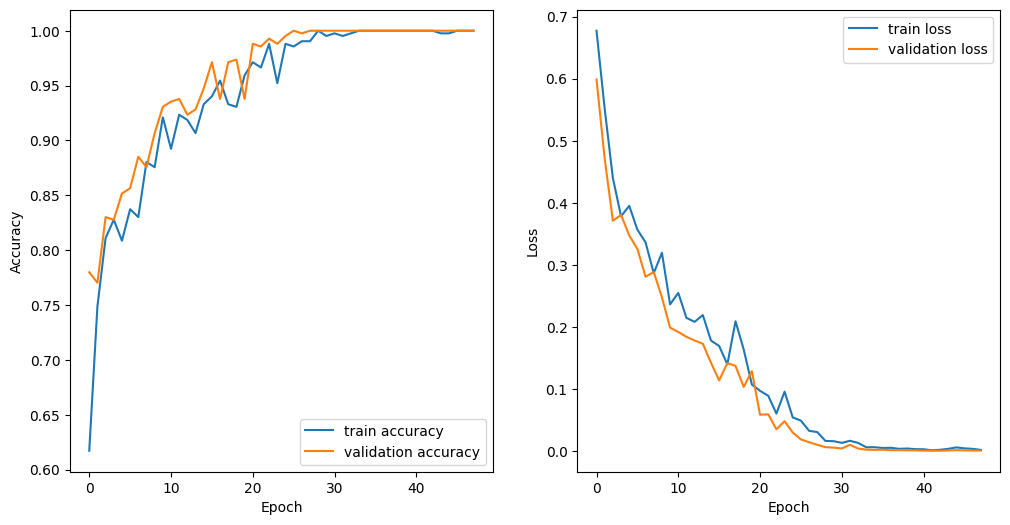

In [15]:
# Plot the training and validation accuracy and loss curves
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="train accuracy")
plt.plot(history.history["val_accuracy"], label="validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [16]:
# Evaluate the model on the test set
y_pred = model.predict(X_test).round().ravel()
test_acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
test_cm = confusion_matrix(y_test, y_pred)
print("Test accuracy:", test_acc)
print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test confusion matrix:")
print(test_cm)

14/14 [==============================] - 0s 737us/step
Test accuracy: 1.0
Test Precision: 1.0
Test Recall: 1.0
Test confusion matrix:
[[209   0]
 [  0 209]]


In [17]:
# Create a binary label dataset from the test set for aif360
test_df = pd.DataFrame(X_test.reshape(-1, 64*64))
test_df["label"] = y_test
test_df["gender"] = 0
test_dataset = BinaryLabelDataset(favorable_label=1, unfavorable_label=0,
                                   df=test_df,
                                   label_names=["label"],
                                   protected_attribute_names=["gender"],
                                   unprivileged_protected_attributes=[0])

In [18]:
# Compute the classification metrics for the test set
metric_classifier = ClassificationMetric(test_dataset,
                                         test_dataset.copy(),
                                         unprivileged_groups=[{"gender": 0}],
                                         privileged_groups=[{"gender": 1}])
print("Accuracy:", metric_classifier.accuracy())
print("Equal opportunity difference:", metric_classifier.equal_opportunity_difference())
print("Average odds difference:", metric_classifier.average_odds_difference())
print("Theil index:", metric_classifier.theil_index())

Accuracy: 1.0
Equal opportunity difference: nan
Average odds difference: nan
Theil index: 0.0


/home/megatron/miniconda3/envs/tf/lib/python3.9/site-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in double_scalars
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/home/megatron/miniconda3/envs/tf/lib/python3.9/site-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in double_scalars
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


In [19]:
# Compute the classification metrics for the test set
#metric_classifier = ClassificationMetric(test_dataset,
#                                         test_dataset.copy(),
#                                         unprivileged_groups=[{"gender": 0}],
#                                         privileged_groups=[{"gender": 1}])
#print("Balanced accuracy:", metric_classifier.balanced_accuracy())
#print("Equal opportunity difference:", metric_classifier.equal_opportunity_difference())
#print("Average odds difference:", metric_classifier.average_odds_difference())
#print("Theil index:", metric_classifier.theil_index())